Creating a custom CNN for detection of cancer from histology specimens.

##first imports for torch, torchvision, numpy, pandas, and os

In [29]:
import torch
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import PIL
import matplotlib as plt

In [30]:
import os
import pandas as pd
import numpy as np
import shutil

In [27]:
#Set up for cuda usage
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print("{} is available".format(device))

cuda is available


In [28]:
# Reorganizing data to subfolders zero and one for pytorch labels implementation
csv_file = r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\train_labels.csv'''
training_path = r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\histo_data\train\\'''
train_path_0 = r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\histo_data\train\0\\'''
train_path_1 = r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\histo_data\train\1\\'''

def move_to_subfolders(csv_file, training_path, train_path_0, train_path_1):
    labels = pd.read_csv(csv_file)


    try:
        for i in range(len(labels)):
            file_name = str(labels.id[i]) + '.tif'
            if labels.label[i].item() == 0:
                file_path_copy = train_path_0
            elif labels.label[i].item() == 1:
                file_path_copy = train_path_1

            file_path_copy = file_path_copy + file_name
            file_origin = training_path + file_name
            shutil.copy2(file_origin, file_path_copy)
    
            os.remove(file_origin)
    except FileNotFoundError:
        print("There are no filese or files have been moved")
    return

In [7]:
move_to_subfolders(csv_file, training_path, train_path_0, train_path_1)

There are no filese or files have been moved


In [ ]:
# Begin to load Data Transforms and split validation set

In [31]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 1000
# percentage of training set to use as validation
valid_size = 0.15
#file directories
data_dir =  r'''C:\Users\gtm12\OneDrive\Documents\Jupyter Notebooks\Kaggle\Histo_cancer\histo_data\\'''
train_dir = data_dir + 'train\\'
#test_dir = data_dir + 'test\\'

In [18]:
# TODO: Define your transforms for the training and validation sets
train_transforms = transforms.Compose([transforms.RandomRotation(15),
                                      transforms.RandomResizedCrop(32),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4,
                                                             contrast=0.4,
                                                             saturation = 0.4,
                                                             hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(48),
                                      transforms.CenterCrop(32),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(48),
                                      transforms.CenterCrop(32),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])


# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
#test_data = datasets.ImageFolder(test_dir, transform=test_transforms)



# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
#    num_workers=num_workers)

# TODO: Using the image datasets and the trainforms, define the dataloaders
#trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
#validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)

In [25]:
print(len(train_loader)*batch_size, len(valid_loader)*batch_size)

188000 34000


Visualize data

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


1


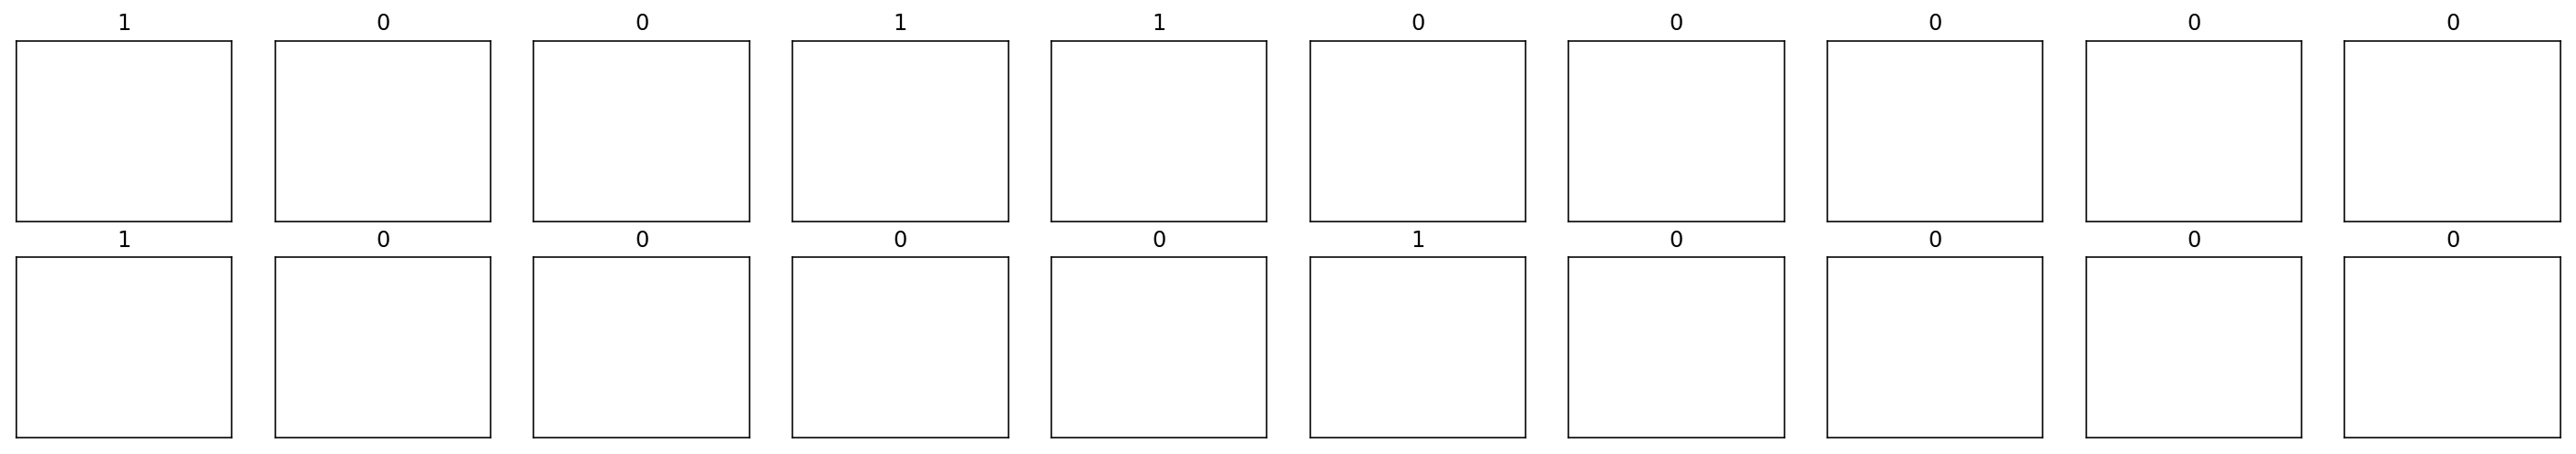

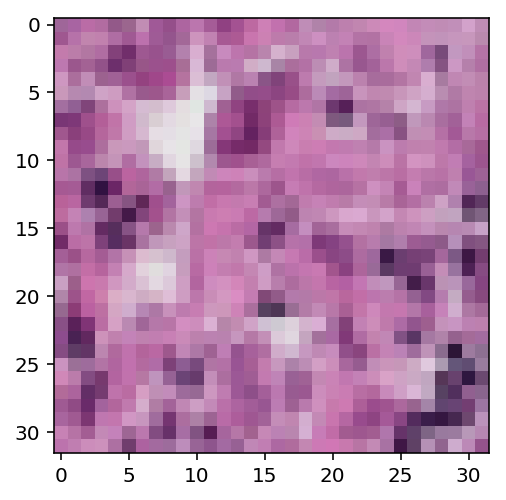

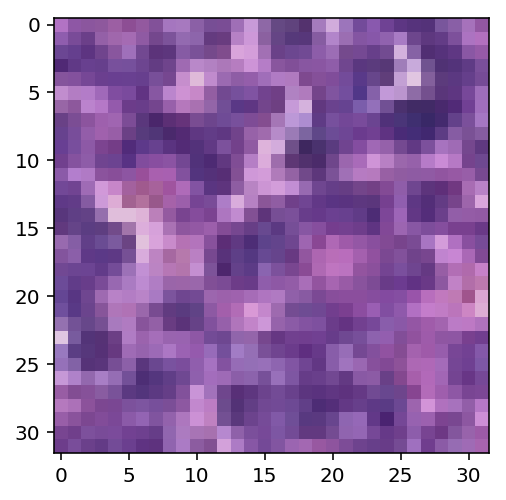

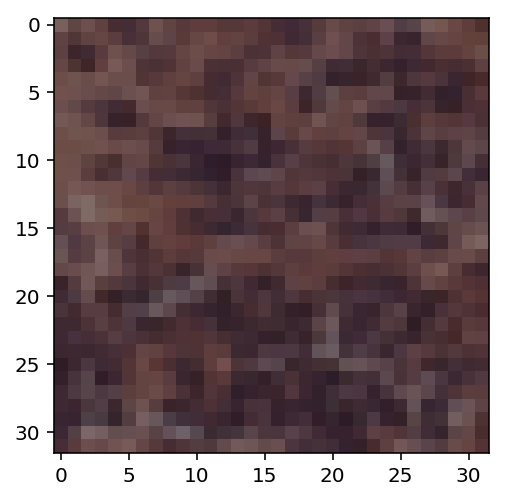

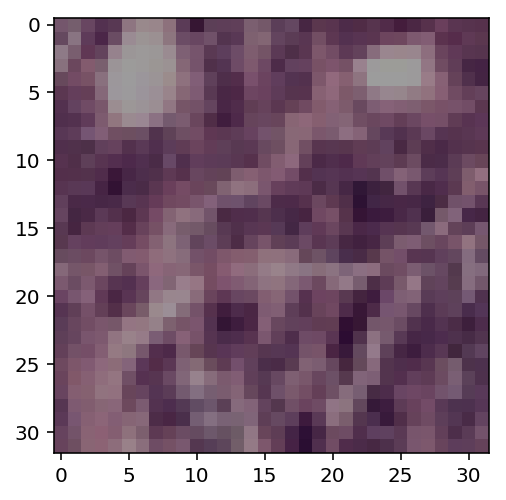

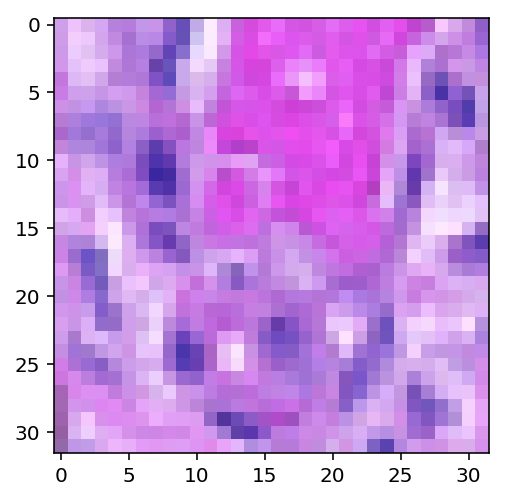

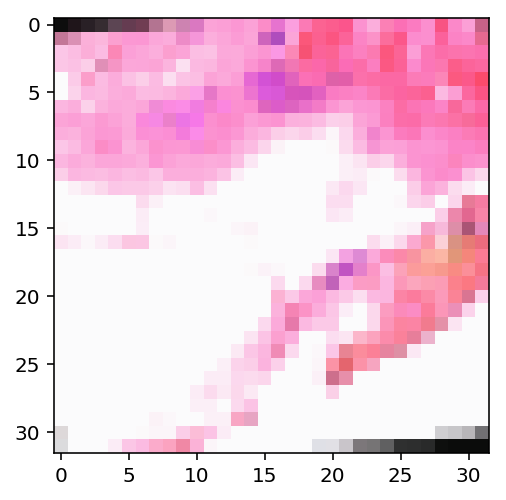

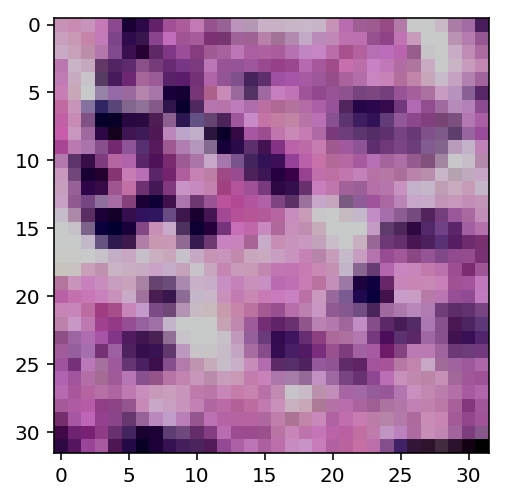

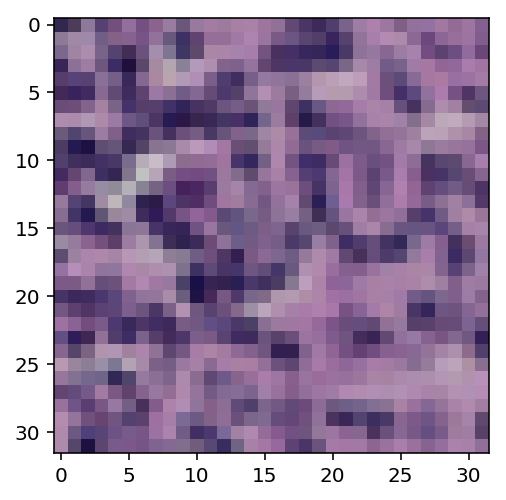

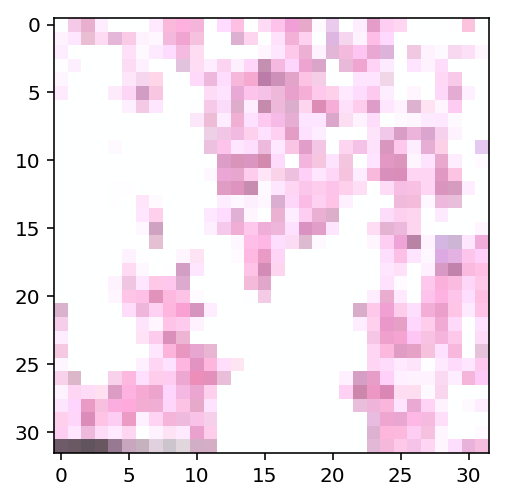

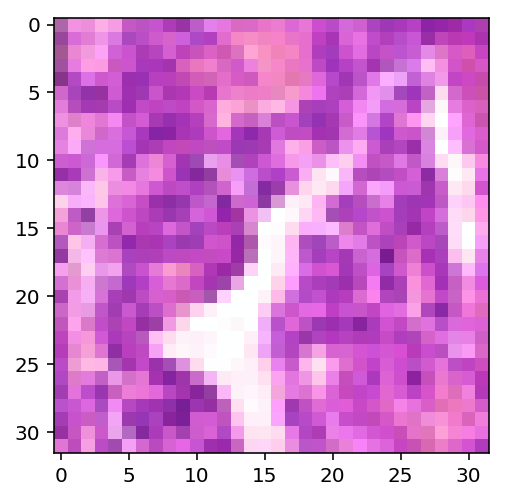

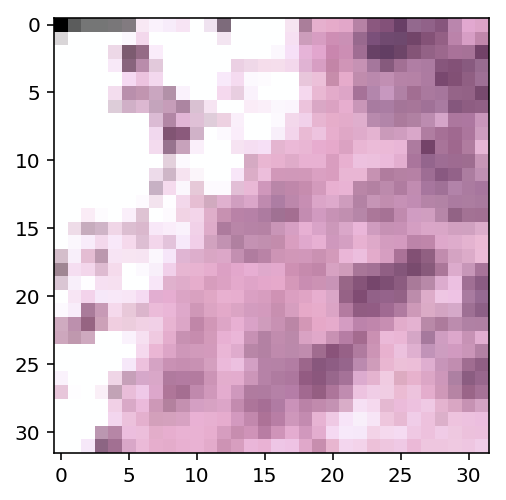

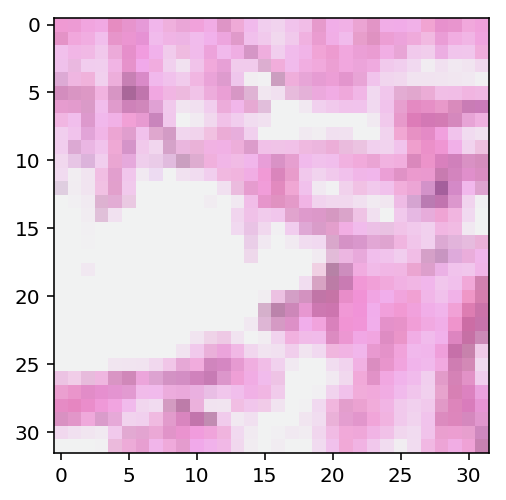

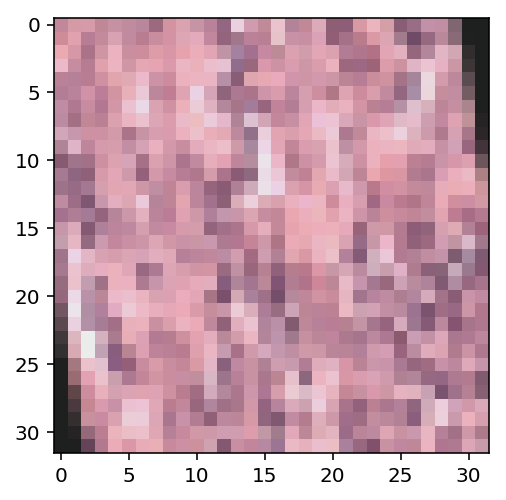

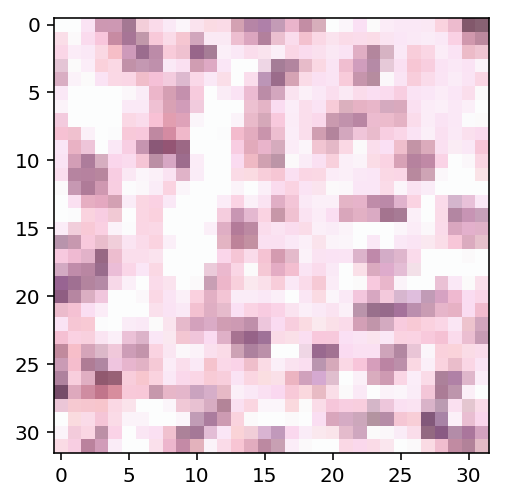

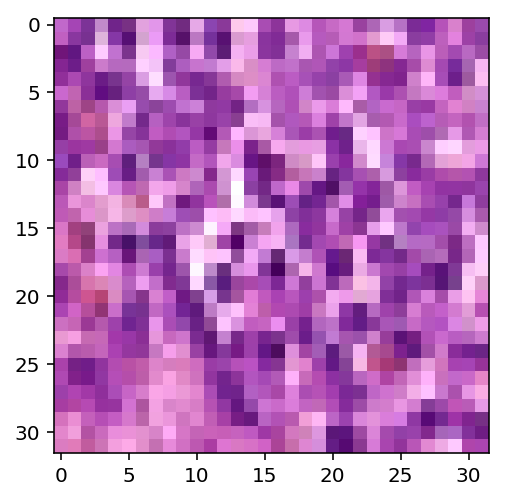

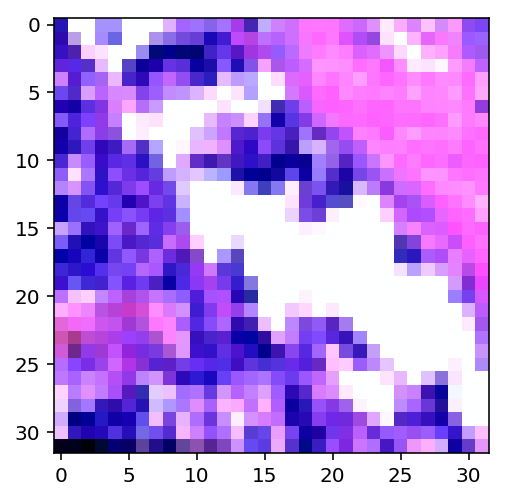

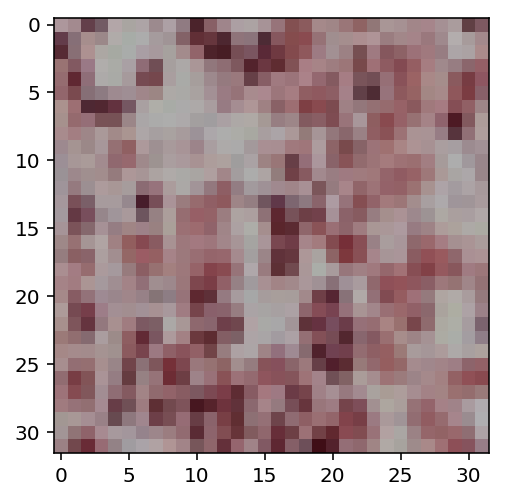

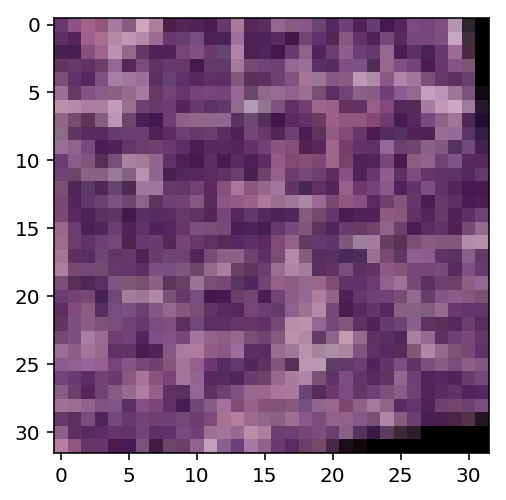

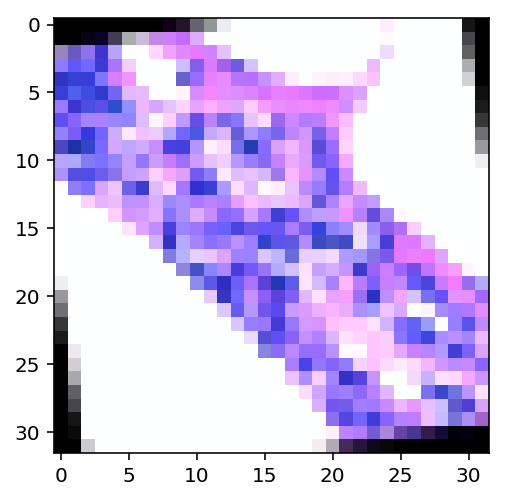

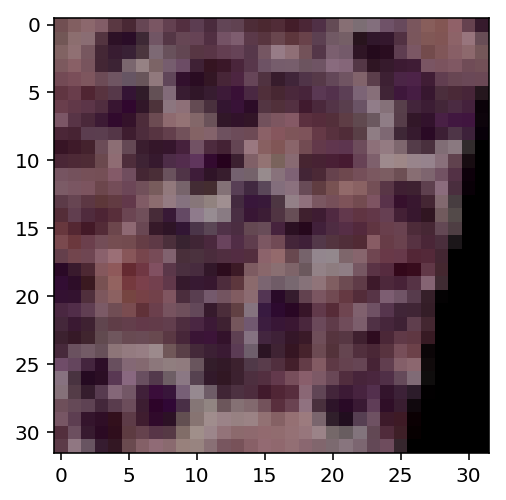

In [55]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print(labels[0].item())
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(labels[idx].item())